In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorcircuit as tc

K = tc.set_backend("tensorflow")

In [2]:
(x_train, y_train), (x_test, y_test) = tc.templates.dataset.mnist_pair_data(
    0, 1, loader=tf.keras.datasets.fashion_mnist
)

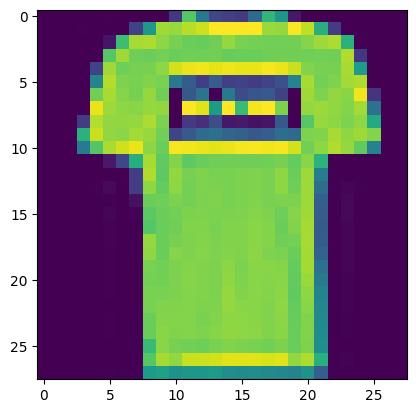

In [3]:
plt.imshow(x_train[0])

In [4]:
x_train = tf.image.pad_to_bounding_box(x_train, 2, 2, 32, 32)
x_test = tf.image.pad_to_bounding_box(x_test, 2, 2, 32, 32)

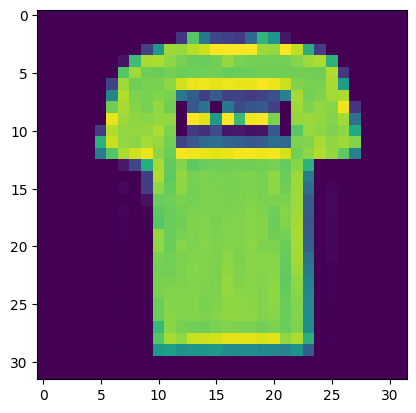

In [5]:
plt.imshow(x_train[0])

In [6]:
batched_ae = K.vmap(tc.templates.dataset.amplitude_encoding, vectorized_argnums=0)

In [7]:
x_train_q = batched_ae(x_train, 10)
x_test_q = batched_ae(x_test, 10)

In [9]:
x_train_q[0]

<tf.Tensor: shape=(1024,), dtype=complex64, numpy=
array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
      dtype=complex64)>

In [23]:
n = 10
blocks = 3


def qml(x, weights):
    c = tc.Circuit(n, inputs=x)
    for j in range(blocks):
        for i in range(n):
            c.rx(i, theta=weights[j, i, 0])
            c.rz(i, theta=weights[j, i, 1])
        for i in range(n - 1):
            c.exp1(i, i + 1, theta=weights[j, i, 2], unitary=tc.gates._zz_matrix)
    outputs = K.stack(
        [K.real(c.expectation([tc.gates.z(), [i]])) for i in range(n)]
        + [K.real(c.expectation([tc.gates.x(), [i]])) for i in range(n)]
    )
    outputs = K.reshape(outputs, [-1])
    return K.sigmoid(K.sum(outputs))


qml_layer = tc.keras.QuantumLayer(qml, weights_shape=[blocks, n, 3])

In [24]:
model = tf.keras.Sequential([qml_layer])
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.legacy.Adam(0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

model.fit(x_train_q, y_train, batch_size=32, epochs=3, validation_split=0.8)

Epoch 1/3
75/75 [==============================] - 50s 320ms/step - loss: 0.5897 - binary_accuracy: 0.8278 - val_loss: 0.3797 - val_binary_accuracy: 0.9661
Epoch 2/3
75/75 [==============================] - 9s 120ms/step - loss: 0.3469 - binary_accuracy: 0.9575 - val_loss: 0.3086 - val_binary_accuracy: 0.9659
Epoch 3/3
75/75 [==============================] - 9s 124ms/step - loss: 0.2949 - binary_accuracy: 0.9596 - val_loss: 0.2685 - val_binary_accuracy: 0.9644
